# Installs

In [0]:
!pip install spacy_langdetect -U gensim --upgrade -q

# Acknowledgements and Overview

Dataset and overview from [Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview): 

**Overview:**

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

# Imports

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import arff
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report
import gensim.models
from gensim.models import Word2Vec
from google.colab import drive
drive.mount('/content/gdrive')
from spacy_langdetect import LanguageDetector
from google.colab import files
import pickle
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
DATA_PATH = '/content/gdrive/My Drive/Data Science/NLP'

# DataFrame

In [0]:
# # #Data loaded in
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train_LbELtWX.zip/Toxic Comment Data.csv')

# #drop id
df = df.drop(columns = 'id')

#downsize the data so Colab doesn't crash
df = df.sample(20000)


# EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 108978 to 13193
Data columns (total 7 columns):
comment_text     20000 non-null object
toxic            20000 non-null int64
severe_toxic     20000 non-null int64
obscene          20000 non-null int64
threat           20000 non-null int64
insult           20000 non-null int64
identity_hate    20000 non-null int64
dtypes: int64(6), object(1)
memory usage: 1.2+ MB


In [15]:
df.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
108978,And You Think You Can really Block a Professor...,1,0,0,0,0,0
150287,neo paganism \n\nwhen i added neo paganism 6 m...,0,0,0,0,0,0
58011,"Agreed. Alan cites Cecil Papers, iv. pp. 394-...",0,0,0,0,0,0


In [16]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.096800,0.011900,0.054350,0.003200,0.052550,0.009450
std,0.295693,0.108439,0.226713,0.056479,0.223139,0.096753
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
df['toxic'].value_counts()

0    18064
1     1936
Name: toxic, dtype: int64

In [18]:
df['severe_toxic'].value_counts()

0    19762
1      238
Name: severe_toxic, dtype: int64

In [19]:
df['obscene'].value_counts()

0    18913
1     1087
Name: obscene, dtype: int64

In [20]:
df['threat'].value_counts()

0    19936
1       64
Name: threat, dtype: int64

In [21]:
df['insult'].value_counts()

0    18949
1     1051
Name: insult, dtype: int64

In [22]:
df['identity_hate'].value_counts()

0    19811
1      189
Name: identity_hate, dtype: int64

In [0]:
#Create a total column to see if there are comments that are true for multiple classifications
df['total'] = df['toxic'] + df['severe_toxic'] + df['obscene'] + df['threat'] + df['insult'] + df['identity_hate']

In [24]:
df['total'].value_counts()

0    17940
1      780
3      532
2      437
4      247
5       57
6        7
Name: total, dtype: int64

# Visual EDA

In [0]:
# #Toxic Comments Word Cloud

# toxic_text = df.loc[df['toxic']==1, ['comment_text']]

# wordcloud_toxic = WordCloud(
#     width = 3000,
#     height = 2000,
#     background_color = 'black',
#     stopwords = STOPWORDS).generate(str(toxic_text))

# pickle_out = open(DATA_PATH + 'wordcloud_toxic.pickle', 'wb')
# pickle.dump(wordcloud_toxic, pickle_out)
# pickle_out.close()

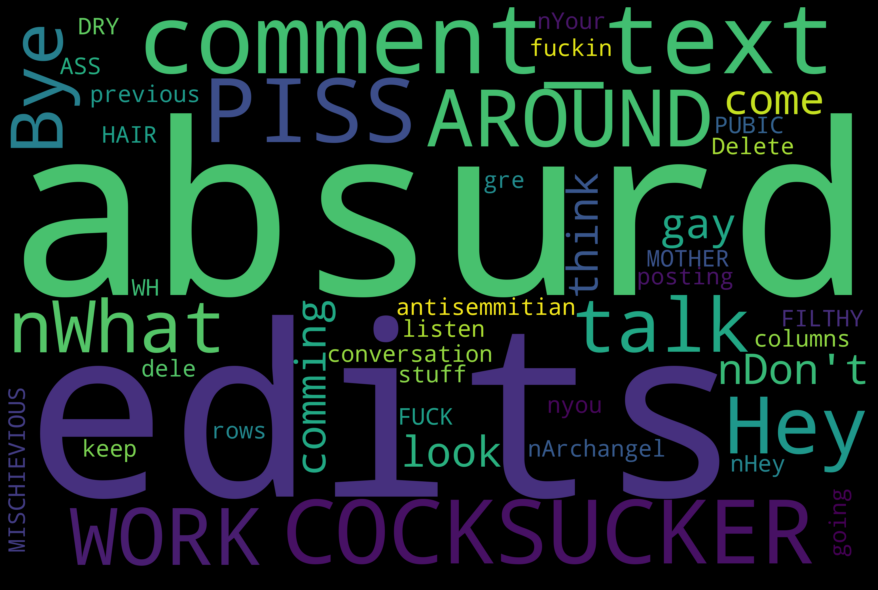

In [35]:
#open wordcloud
pickle_in = open(DATA_PATH + 'wordcloud_toxic.pickle', 'rb')
wordcloud_toxic = pickle.load(pickle_in)

fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_toxic, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [0]:
# #Severe Toxic Comments Word Cloud

# severe_toxic_text = df.loc[df['severe_toxic']==1, ['comment_text']]

# wordcloud_severe_toxic = WordCloud(
#     width = 3000,
#     height = 2000,
#     background_color = 'black',
#     stopwords = STOPWORDS).generate(str(severe_toxic_text))

# pickle_out = open(DATA_PATH + 'wordcloud_severe_toxic.pickle', 'wb')
# pickle.dump(wordcloud_severe_toxic, pickle_out)
# pickle_out.close()

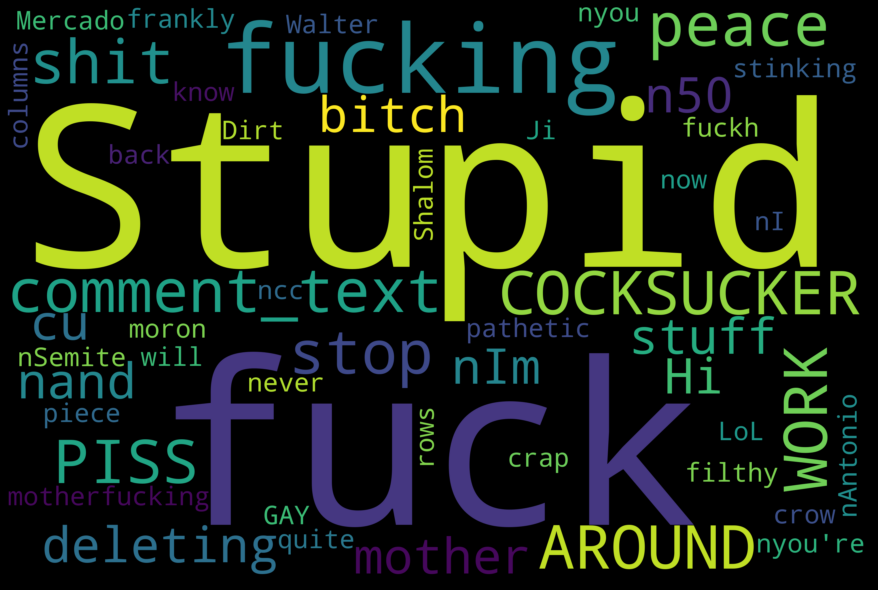

In [0]:
#open wordcloud
pickle_in = open(DATA_PATH + 'wordcloud_severe_toxic.pickle', 'rb')
wordcloud_severe_toxic = pickle.load(pickle_in)

fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_severe_toxic, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [0]:
# #Obscene Comments Word Cloud

# obscene_text = df.loc[df['obscene']==1, ['comment_text']]

# wordcloud_obscene = WordCloud(
#     width = 3000,
#     height = 2000,
#     background_color = 'black',
#     stopwords = STOPWORDS).generate(str(obscene_text))

# pickle_out = open(DATA_PATH + 'wordcloud_obscene.pickle', 'wb')
# pickle.dump(wordcloud_obscene, pickle_out)
# pickle_out.close()

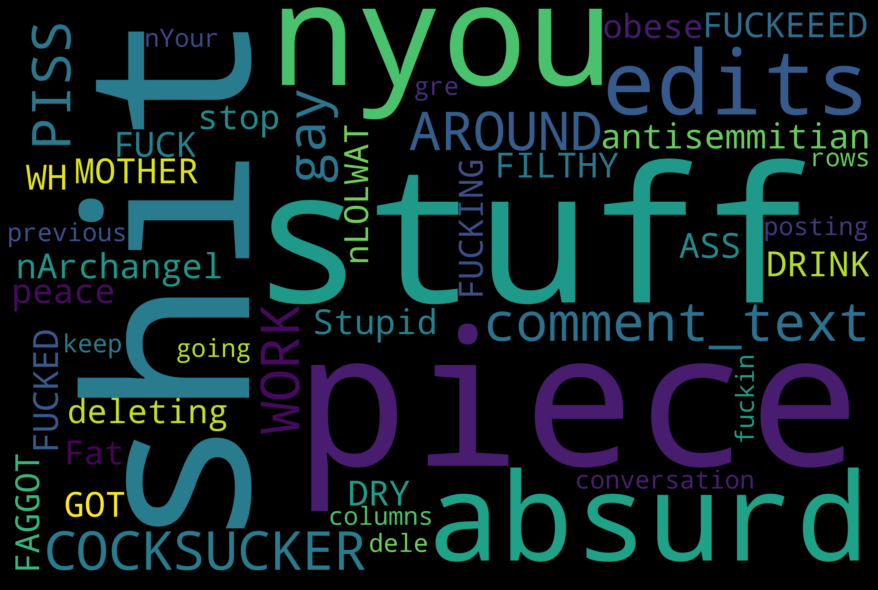

In [0]:
#open wordcloud
pickle_in = open(DATA_PATH + 'wordcloud_obscene.pickle', 'rb')
wordcloud_obscene = pickle.load(pickle_in)

fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obscene, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [0]:
# #Threat Comments Word Cloud

# threat_text = df.loc[df['threat']==1, ['comment_text']]

# wordcloud_threat = WordCloud(
#     width = 3000,
#     height = 2000,
#     background_color = 'black',
#     stopwords = STOPWORDS).generate(str(threat_text))

# pickle_out = open(DATA_PATH + 'wordcloud_threat.pickle', 'wb')
# pickle.dump(wordcloud_threat, pickle_out)
# pickle_out.close()

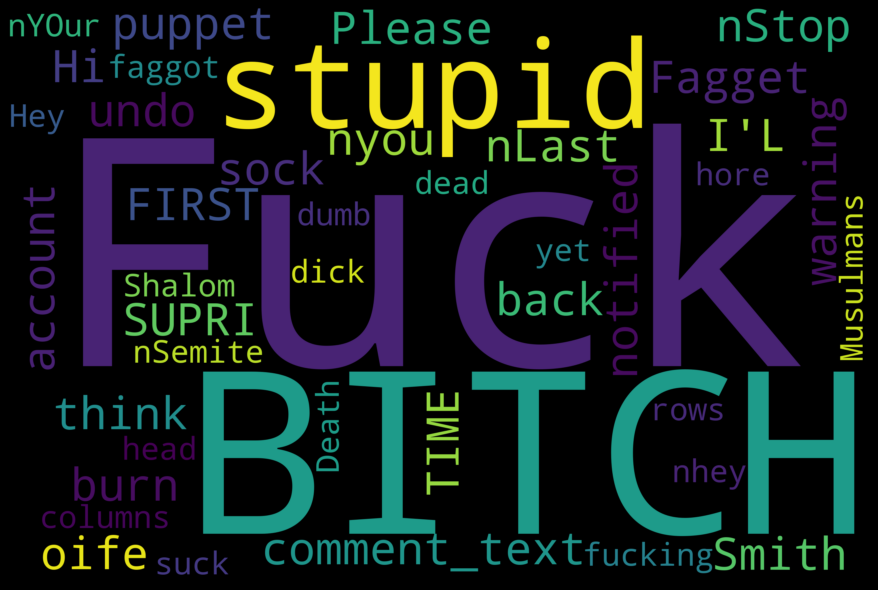

In [0]:
#open wordcloud
pickle_in = open(DATA_PATH + 'wordcloud_threat.pickle', 'rb')
wordcloud_threat = pickle.load(pickle_in)

fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_threat, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [0]:
# #Insult Comments Word Cloud

# insult_text = df.loc[df['insult']==1, ['comment_text']]

# wordcloud_insult = WordCloud(
#     width = 3000,
#     height = 2000,
#     background_color = 'black',
#     stopwords = STOPWORDS).generate(str(insult_text))

# pickle_out = open(DATA_PATH + 'wordcloud_insult.pickle', 'wb')
# pickle.dump(wordcloud_insult, pickle_out)
# pickle_out.close()

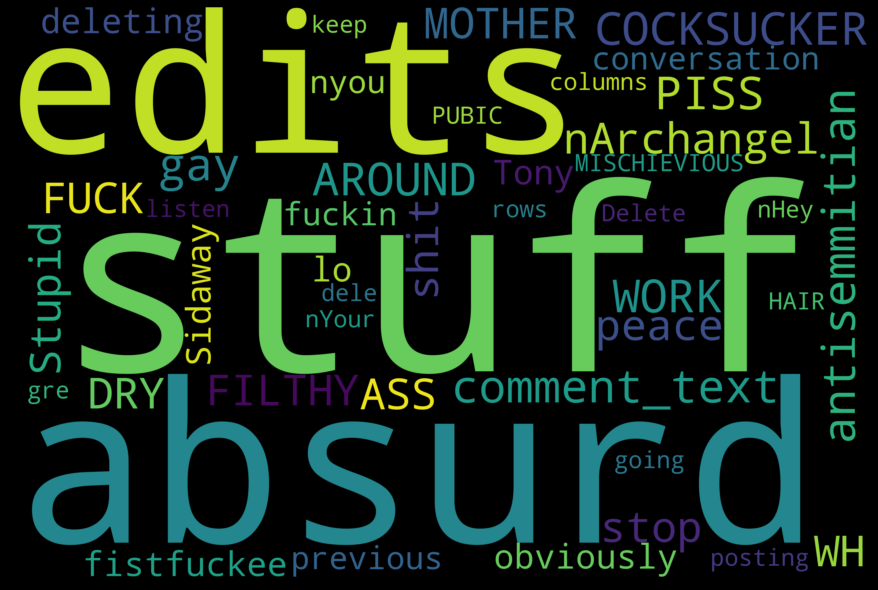

In [0]:
#open wordcloud
pickle_in = open(DATA_PATH + 'wordcloud_insult.pickle', 'rb')
wordcloud_insult = pickle.load(pickle_in)

fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_insult, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [0]:
# #Identity Hate Comments Word Cloud

# identity_hate_text = df.loc[df['identity_hate']==1, ['comment_text']]

# wordcloud_hate = WordCloud(
#     width = 3000,
#     height = 2000,
#     background_color = 'black',
#     stopwords = STOPWORDS).generate(str(identity_hate_text))

# pickle_out = open(DATA_PATH + 'wordcloud_hate.pickle', 'wb')
# pickle.dump(wordcloud_hate, pickle_out)
# pickle_out.close()

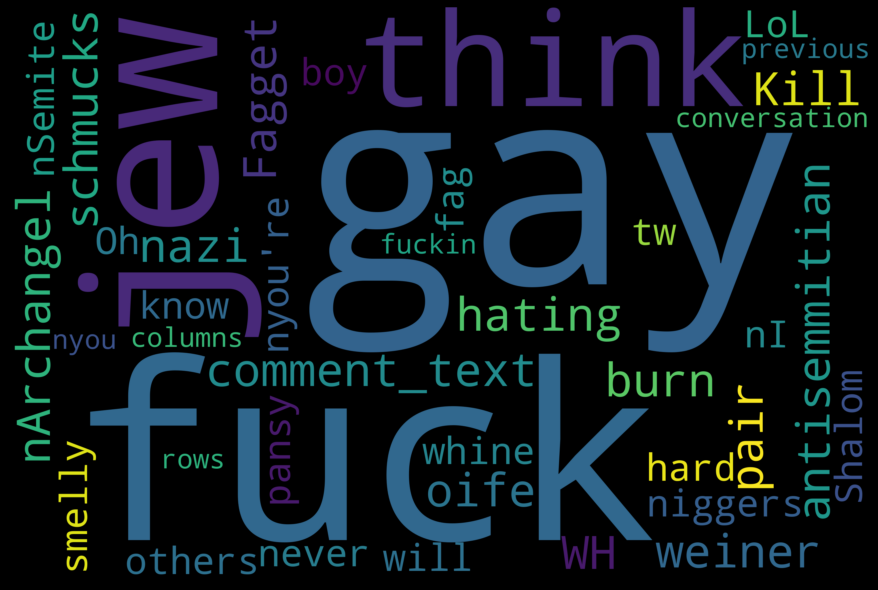

In [0]:
#open wordcloud
pickle_in = open(DATA_PATH + 'wordcloud_hate.pickle', 'rb')
wordcloud_hate = pickle.load(pickle_in)

fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_hate, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

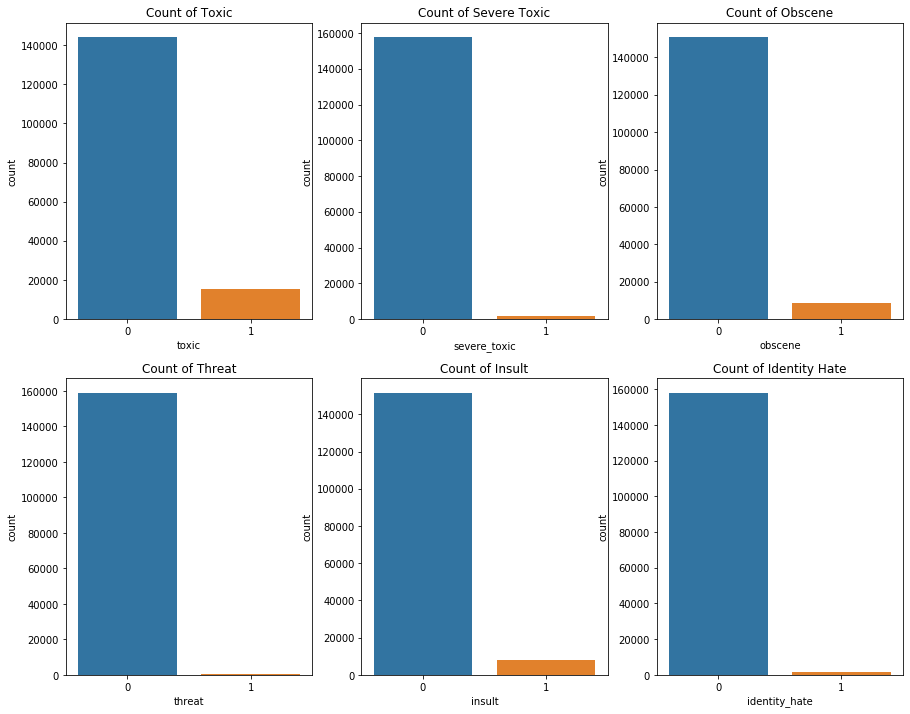

In [0]:
plt.figure(figsize = (15,12))

plt.subplot(2,3,1)
sns.countplot(x = 'toxic', data = df)
plt.title('Count of Toxic')

plt.subplot(2,3,2)
sns.countplot(x = 'severe_toxic', data = df)
plt.title('Count of Severe Toxic')

plt.subplot(2,3,3)
sns.countplot(x = 'obscene', data = df)
plt.title('Count of Obscene')

plt.subplot(2,3,4)
sns.countplot(x = 'threat', data = df)
plt.title('Count of Threat')

plt.subplot(2,3,5)
sns.countplot(x = 'insult', data = df)
plt.title('Count of Insult')

plt.subplot(2,3,6)
sns.countplot(x = 'identity_hate', data = df)
plt.title('Count of Identity Hate')

plt.show()

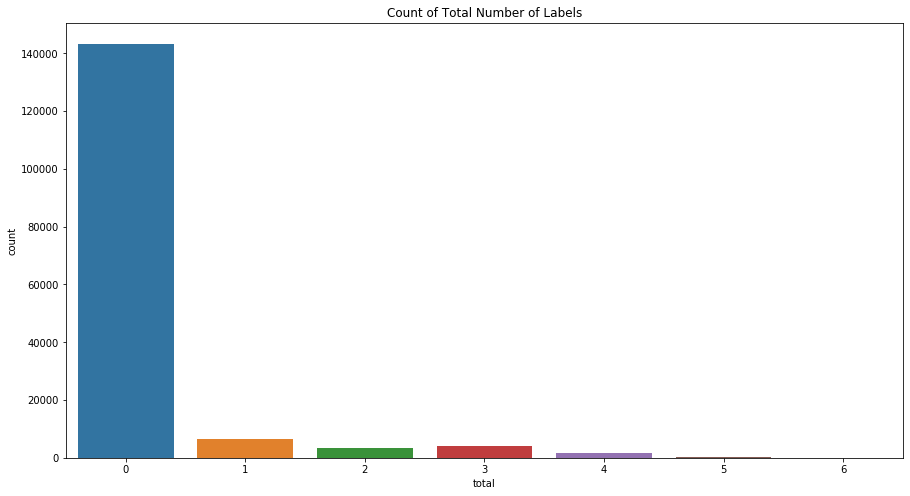

In [0]:
plt.figure(figsize = (15,8))
sns.countplot(x = 'total', data = df)
plt.title('Count of Total Number of Labels')
plt.show()

# Text Preprocessing

In [0]:
# #figure out how many of each word is the the comments
# value_counts = pd.DataFrame(df['comment_text'].str.split(' ', expand=True).stack().value_counts())

# # pickle value_counts for faster runtime
# pickle_out = open(DATA_PATH + 'value_counts.pickle', 'wb')
# pickle.dump(value_counts, pickle_out)
# pickle_out.close()

In [0]:
#open value_counts
pickle_in = open(DATA_PATH + 'value_counts.pickle', 'rb')
value_counts = pickle.load(pickle_in)

In [0]:
# #drop words that are in the comments less than 5 times
# words_to_drop = set(value_counts.loc[(value_counts[0] < 5)].index.values.tolist())

# # pickle words_to_drop for faster runtime
# pickle_out = open(DATA_PATH + 'words_to_drop.pickle', 'wb')
# pickle.dump(words_to_drop, pickle_out)
# pickle_out.close()

In [0]:
#open words_to_drop
pickle_in = open(DATA_PATH + 'words_to_drop.pickle', 'rb')
words_to_drop = pickle.load(pickle_in)

In [0]:
df['comment_text'] = df['comment_text'].apply(lambda x: [item for item in str(x).split() if item not in words_to_drop])

In [0]:
#make back into a string so it can be cleaned
df['comment_text'] = df['comment_text'].apply(' '.join)

In [0]:
# #Convert to a string and remove commas so that it can be cleaned
# df['comment_text'] = df['comment_text'].apply(', '.join)
# df['comment_text'] = df['comment_text'].str.replace(',', '')

In [0]:
def preprocess(docs): 
    lemmatizer = WordNetLemmatizer()
    preprocessed = []

    for doc in docs:
        tokenized = word_tokenize(doc)
        cleaned = [lemmatizer.lemmatize(token.lower())
        for token in tokenized
        if token.lower() not in stopwords.words('english')
        if token.isalpha()]
    
        untokenized = ' '.join(cleaned)
        preprocessed.append(untokenized)

    return preprocessed 

df['comment_text'] = df['comment_text'].apply(lambda x: preprocess(x))

# pickle df for faster runtime
pickle_out = open(DATA_PATH + 'df.pickle', 'wb')
pickle.dump(df, pickle_out)
pickle_out.close()

In [0]:
#open df
pickle_in = open(DATA_PATH + 'df.pickle', 'rb')
df = pickle.load(pickle_in)

# Parse and Tokenize the Text

In [0]:
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)
nlp.max_length = 6000
df['comment_text'] = df['comment_text'].apply(nlp)

# Check for Non-English Words

In [0]:
#create a score for each row on the English language
score = df['comment_text'].apply(lambda x: x._.language)

In [0]:
#add language and score columns
df = pd.concat([df, pd.DataFrame(list(score), index = score.index)], axis = 1)

In [0]:
#see how many different languages are in the text
df['language'].value_counts()

en         17945
fr           287
af           234
it           179
nl           148
da           110
sv           104
ro           103
no            96
et            80
so            71
tl            69
ca            62
cy            59
es            56
id            51
pl            49
UNKNOWN       46
fi            44
pt            35
sw            27
sq            23
hr            22
sl            20
tr            20
de            18
sk            14
hu            12
vi             5
lv             4
cs             4
lt             3
Name: language, dtype: int64

In [0]:
#view non english languages
df.loc[df['language']!= 'en']

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,language,score
141800,"(kiss, u, look, u, playing, ur, need, man, ur,...",0,0,0,0,0,0,so,0.714284
149405,"(nothing, prove, negative, number, defined, pr...",0,0,0,0,0,0,ro,0.571428
26986,"(disagree, put, inquiry, appropriate, talk, page)",0,0,0,0,0,0,it,0.999995
22759,"(blog, believe, version, janes, newspaper, bec...",0,0,0,0,0,0,da,0.857138
113472,"(barnstar, original, barnstar)",0,0,0,0,0,0,sv,0.999996
...,...,...,...,...,...,...,...,...,...
19013,"(ha, jewish, cock)",1,0,1,0,0,0,pl,0.714283
150846,"(october, utc, ok)",0,0,0,0,0,0,sv,0.999997
70982,"(hello, welcome)",0,0,0,0,0,0,nl,0.571427
97962,"(five, little, indian, else, kolkata, chronic)",0,0,0,0,0,0,it,0.571426


In [0]:
#view lowest scoring english language
df.loc[df['language']== 'en'].sort_values(by = 'score')

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,language,score
78828,"(article, need, tell, name, language, jun, utc)",0,0,0,0,0,0,en,0.285715
15710,"(stop, enforcement)",0,0,0,0,0,0,en,0.285715
90711,"(i, m, total, douchebag)",0,0,0,0,0,0,en,0.285715
34264,"(do, nt, care, like, said, keep, shitty, grammar)",1,0,1,0,0,0,en,0.428568
10486,"(hi, i, m, skating, good, talented, would, muc...",0,0,0,0,0,0,en,0.428569
...,...,...,...,...,...,...,...,...,...
94098,"(appreciate, reasoned, explanation, edits, sti...",0,0,0,0,0,0,en,1.000000
100924,"(notrhbysouthbanof, suck, cock, notrhbysouthba...",1,1,1,0,1,0,en,1.000000
22265,"(patent, nonsense, admitting, source, wrong, s...",0,0,0,0,0,0,en,1.000000
81187,"(understanding, wikified, language, hi, thanks...",0,0,0,0,0,0,en,1.000000


In [0]:
#view UNKNOWN language

df.loc[df['language'] == 'UNKNOWN']

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,language,score
29172,(),0,0,0,0,0,0,UNKNOWN,0.0
25940,(),0,0,0,0,0,0,UNKNOWN,0.0
114172,(),0,0,0,0,0,0,UNKNOWN,0.0
41640,(),0,0,0,0,0,0,UNKNOWN,0.0
126010,(),0,0,0,0,0,0,UNKNOWN,0.0
9919,(),0,0,0,0,0,0,UNKNOWN,0.0
74393,(),0,0,0,0,0,0,UNKNOWN,0.0
67217,(),0,0,0,0,0,0,UNKNOWN,0.0
107314,(),0,0,0,0,0,0,UNKNOWN,0.0
94038,(),0,0,0,0,0,0,UNKNOWN,0.0


In [0]:
#Drop UNKNOWN since there is no comment text
df.drop(df.loc[df['language'] == 'UNKNOWN'].index, inplace = True)

In [0]:
#Drop language and score columns to minimize ram
df.drop(columns = ['score', 'language'], inplace = True)

# Save as Texts

In [0]:
#save them as texts
df['comment_text'] = df['comment_text'].apply(lambda x: x.text)

#CountVectorizer BoW

This was run with 20,000 rows of data. This had to be done in order to prevent Colab from maxing out at 25 GB of ram. 

In [0]:
vectorizer1 = CountVectorizer(analyzer='word')
X1 = vectorizer1.fit_transform(df['comment_text'])

In [0]:
#Add BoW to dataframe
df = df.reset_index().join(pd.DataFrame(X1.toarray(), columns=vectorizer1.get_feature_names()), lsuffix = 'L')

In [0]:
#Train Test Split

X = df.drop(columns = ['languageL', 'scoreL', 'index', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threatL', 'insultL', 'identity_hate'])
y = df[['toxic', 'severe_toxic', 'obscene', 'threatL', 'insultL', 'identity_hate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 21)

In [0]:
#Random Forest Classifer
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
#Classication Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.67      0.21      0.31        39
           2       0.88      0.83      0.85       202
           3       1.00      0.10      0.18        10
           4       0.85      0.74      0.79       199
           5       0.86      0.14      0.24        42

   micro avg       0.86      0.67      0.75       492
   macro avg       0.71      0.34      0.40       492
weighted avg       0.85      0.67      0.72       492
 samples avg       0.05      0.04      0.04       492



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


# CountVectorizer BoW 1 and 2-Gram

In order to run this count vector, df must be reset to a smaller sample to minimize ram usage. The below was completed with df being reset to 5,000 and cleaning redone. 

In [0]:
vectorizer1 = CountVectorizer(analyzer='word', ngram_range = (1,2))
X1 = vectorizer1.fit_transform(df['comment_text'])

df = df.reset_index().join(pd.DataFrame(X1.toarray(), columns=vectorizer1.get_feature_names()), lsuffix = 'L')

In [0]:
#Train Test Split 

X = df.drop(columns = ['index', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threatL', 'insultL', 'identity_hate'])
y = df[['toxic', 'severe_toxic', 'obscene', 'threatL', 'insultL', 'identity_hate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 21)

In [0]:
#Random Forest Classifier

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
#Classication Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.49      0.63       106
           1       0.67      0.14      0.24        14
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.79      0.41      0.54        56
           5       0.00      0.00      0.00        10

   micro avg       0.86      0.41      0.55       189
   macro avg       0.39      0.17      0.24       189
weighted avg       0.79      0.41      0.53       189
 samples avg       0.05      0.04      0.04       189



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


# Tf-idf Vectorizer 

In order to run this count vector, df must be reset to a smaller sample to minimize ram usage. The below was completed with df being reset to 8,000 and cleaning redone. 

In [0]:
vectorizer1 = TfidfVectorizer(min_df=2, use_idf=True, norm=u'l2', smooth_idf=True, ngram_range = (1,2))

X1 = vectorizer1.fit_transform(df['comment_text'])

df = df.reset_index().join(pd.DataFrame(X1.toarray(), columns=vectorizer1.get_feature_names()), lsuffix = 'L')

In [0]:
#Train Test Split 

X = df.drop(columns = ['id', 'index', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threatL', 'insultL', 'identity_hate'])
y = df[['toxic', 'severe_toxic', 'obscene', 'threatL', 'insultL', 'identity_hate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 21)

In [0]:
#Random Forest Classifier

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
#Classication Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.41      0.57       150
           1       0.25      0.08      0.12        13
           2       0.90      0.46      0.61        78
           3       0.00      0.00      0.00         2
           4       0.78      0.48      0.60        75
           5       0.00      0.00      0.00        12

   micro avg       0.86      0.41      0.55       330
   macro avg       0.48      0.24      0.32       330
weighted avg       0.83      0.41      0.54       330
 samples avg       0.03      0.03      0.03       330



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
